https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [16]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing Libraries
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [3]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [4]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


In [5]:
cdata = GetCIFAR10_TrainData(os.chdir(".."))
trainset = cdata.download_train_data()
testset = cdata.download_test_data()

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
len(trainset), len(validset), len(testset)

(45000, 5000, 10000)

In [7]:
BATCH_SIZE = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# The Model - RESNET18


In [8]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [9]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        self.conv = conv3x3(in_channels=3, out_channels=64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=64, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=128, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block=block, out_channels=256, blocks=layers[2], stride=2)
        # self.layer4 = self.make_layer(block=block, out_channels=512, blocks=layers[3], stride=2)

        self.avg_pool = nn.AvgPool2d(4)
        # self.fc = nn.Linear(256, num_classes)
        self.fc = nn.Linear(1024, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    # return ResNet(ResidualBlock, [2, 2, 2, 2])
    return ResNet(ResidualBlock, [3, 3, 3])

In [10]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
           Dropout-6           [-1, 64, 32, 32]               0
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
          Dropout-10           [-1, 64, 32, 32]               0
             ReLU-11           [-1, 64, 32, 32]               0
    ResidualBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [11]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        # train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        # print statistics
        
        running_loss += loss.item()
        pbar.set_description(desc=f'Batch_id={batch_idx} Batch Loss={loss.item()} Running Loss={running_loss} Running Accuracy={100*correct/processed:0.2f}')
        # train_acc.append(100*correct/processed)
    
    train_losses.append(running_loss)
    train_acc.append(100*correct/processed)

In [12]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified, correct / len(test_dataloader.dataset)

In [13]:
def model_evaluation(model, device, loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = F.nll_loss(y_pred, y)
        
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y.view_as(pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    epoch_loss / len(loader.dataset), epoch_acc, len(loader.dataset),
    100. * epoch_acc / len(loader.dataset)))

    return epoch_loss, epoch_acc / len(loader.dataset)

In [14]:
# Defining parameters

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [15]:
import pandas

def save_to_csv(csvname, train_losses, train_accs, test_losses, test_accs):
  df = pandas.DataFrame()
  df["epoch"] = [i+1 for i in range(len(train_losses))]
  df["train_loss"] = train_losses
  df["test_loss"] = test_losses
  df["train_acc"] = train_accs
  df["test_acc"] = test_accs
  df.to_csv(csvname)

In [17]:
# Training the model

train_acc = []
train_losses = []
valid_accs = []
valid_losses = []
test_acc = []
test_losses = []
min_valid_loss = None
max_acc = None

EPOCHS = 120

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)

    # Validating the model for the current epoch
    valid_loss, valid_acc = model_evaluation(model, device, validloader)  

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if not min_valid_loss:
      min_valid_loss = valid_loss
    else:
      if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model, "best_model.pickle")

    # scheduler.step(train_losses[-1])
    scheduler.step(valid_loss)

    misclassified, test_acc2 = model_testing(model, device, testloader, test_acc, test_losses)

    if not max_acc:
      max_acc = test_acc2
    else:
      if test_acc2 > max_acc:
        max_acc = test_acc2
        torch.save(model, "best_test_acc_model.pickle")

    save_to_csv("16_resnet_3_3_3_inchannels_64_dropout_less_threshold.csv", train_losses, train_acc, test_losses, test_acc)


EPOCHS : 0


Batch_id=87 Batch Loss=1.4870096445083618 Running Loss=156.62847089767456 Running Accuracy=34.65: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0035, Accuracy: 1986/5000 (39.72%)


Test set: Average loss: 1.7478, Accuracy: 4027/10000 (40.27%)

EPOCHS : 1


Batch_id=87 Batch Loss=1.1261922121047974 Running Loss=114.41598773002625 Running Accuracy=52.85: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]



Validation set: Average loss: 0.0025, Accuracy: 2833/5000 (56.66%)


Test set: Average loss: 1.2353, Accuracy: 5699/10000 (56.99%)

EPOCHS : 2


Batch_id=87 Batch Loss=1.0517187118530273 Running Loss=93.53048986196518 Running Accuracy=62.10: 100%|██████████| 88/88 [00:17<00:00,  4.95it/s]



Validation set: Average loss: 0.0021, Accuracy: 3214/5000 (64.28%)


Test set: Average loss: 1.0571, Accuracy: 6473/10000 (64.73%)

EPOCHS : 3


Batch_id=87 Batch Loss=0.8606631755828857 Running Loss=81.25495159626007 Running Accuracy=67.29: 100%|██████████| 88/88 [00:18<00:00,  4.85it/s]



Validation set: Average loss: 0.0018, Accuracy: 3402/5000 (68.04%)


Test set: Average loss: 0.9335, Accuracy: 6813/10000 (68.13%)

EPOCHS : 4


Batch_id=87 Batch Loss=0.7102836966514587 Running Loss=71.29791069030762 Running Accuracy=71.38: 100%|██████████| 88/88 [00:18<00:00,  4.89it/s]



Validation set: Average loss: 0.0015, Accuracy: 3725/5000 (74.50%)


Test set: Average loss: 0.7529, Accuracy: 7453/10000 (74.53%)

EPOCHS : 5


Batch_id=87 Batch Loss=0.7942198514938354 Running Loss=65.43905889987946 Running Accuracy=73.65: 100%|██████████| 88/88 [00:17<00:00,  4.96it/s]



Validation set: Average loss: 0.0014, Accuracy: 3867/5000 (77.34%)


Test set: Average loss: 0.6792, Accuracy: 7697/10000 (76.97%)

EPOCHS : 6


Batch_id=87 Batch Loss=0.6727298498153687 Running Loss=60.73361802101135 Running Accuracy=75.87: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0013, Accuracy: 3917/5000 (78.34%)


Test set: Average loss: 0.6385, Accuracy: 7847/10000 (78.47%)

EPOCHS : 7


Batch_id=87 Batch Loss=0.7144920825958252 Running Loss=56.83347648382187 Running Accuracy=77.67: 100%|██████████| 88/88 [00:17<00:00,  4.96it/s]



Validation set: Average loss: 0.0013, Accuracy: 3880/5000 (77.60%)


Test set: Average loss: 0.6728, Accuracy: 7703/10000 (77.03%)

EPOCHS : 8


Batch_id=87 Batch Loss=0.5202427506446838 Running Loss=53.06162226200104 Running Accuracy=78.93: 100%|██████████| 88/88 [00:18<00:00,  4.86it/s]



Validation set: Average loss: 0.0012, Accuracy: 3965/5000 (79.30%)


Test set: Average loss: 0.5954, Accuracy: 7982/10000 (79.82%)

EPOCHS : 9


Batch_id=87 Batch Loss=0.5123599171638489 Running Loss=50.642078042030334 Running Accuracy=79.96: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]



Validation set: Average loss: 0.0012, Accuracy: 3961/5000 (79.22%)


Test set: Average loss: 0.5945, Accuracy: 8006/10000 (80.06%)

EPOCHS : 10


Batch_id=87 Batch Loss=0.5332925915718079 Running Loss=48.38836592435837 Running Accuracy=80.75: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]



Validation set: Average loss: 0.0011, Accuracy: 4062/5000 (81.24%)


Test set: Average loss: 0.5683, Accuracy: 8101/10000 (81.01%)

EPOCHS : 11


Batch_id=87 Batch Loss=0.44714727997779846 Running Loss=45.65813109278679 Running Accuracy=81.99: 100%|██████████| 88/88 [00:17<00:00,  4.95it/s]



Validation set: Average loss: 0.0011, Accuracy: 4052/5000 (81.04%)


Test set: Average loss: 0.5811, Accuracy: 8044/10000 (80.44%)

EPOCHS : 12


Batch_id=87 Batch Loss=0.5809598565101624 Running Loss=43.60525557398796 Running Accuracy=82.70: 100%|██████████| 88/88 [00:17<00:00,  4.94it/s]



Validation set: Average loss: 0.0010, Accuracy: 4173/5000 (83.46%)


Test set: Average loss: 0.4899, Accuracy: 8389/10000 (83.89%)

EPOCHS : 13


Batch_id=87 Batch Loss=0.4372301697731018 Running Loss=41.29931217432022 Running Accuracy=83.49: 100%|██████████| 88/88 [00:18<00:00,  4.89it/s]



Validation set: Average loss: 0.0010, Accuracy: 4173/5000 (83.46%)


Test set: Average loss: 0.4910, Accuracy: 8312/10000 (83.12%)

EPOCHS : 14


Batch_id=87 Batch Loss=0.491743803024292 Running Loss=39.54989716410637 Running Accuracy=84.23: 100%|██████████| 88/88 [00:18<00:00,  4.84it/s]



Validation set: Average loss: 0.0010, Accuracy: 4159/5000 (83.18%)


Test set: Average loss: 0.5034, Accuracy: 8323/10000 (83.23%)

EPOCHS : 15


Batch_id=87 Batch Loss=0.41723719239234924 Running Loss=38.12618991732597 Running Accuracy=84.86: 100%|██████████| 88/88 [00:17<00:00,  4.98it/s]



Validation set: Average loss: 0.0010, Accuracy: 4143/5000 (82.86%)

Epoch 00016: reducing learning rate of group 0 to 1.0000e-03.

Test set: Average loss: 0.5090, Accuracy: 8347/10000 (83.47%)

EPOCHS : 16


Batch_id=87 Batch Loss=0.3527681529521942 Running Loss=31.93005070090294 Running Accuracy=87.38: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]



Validation set: Average loss: 0.0008, Accuracy: 4345/5000 (86.90%)


Test set: Average loss: 0.3711, Accuracy: 8740/10000 (87.40%)

EPOCHS : 17


Batch_id=87 Batch Loss=0.346331924200058 Running Loss=29.734554082155228 Running Accuracy=88.19: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]



Validation set: Average loss: 0.0007, Accuracy: 4365/5000 (87.30%)


Test set: Average loss: 0.3639, Accuracy: 8754/10000 (87.54%)

EPOCHS : 18


Batch_id=87 Batch Loss=0.36712974309921265 Running Loss=29.324844479560852 Running Accuracy=88.26: 100%|██████████| 88/88 [00:17<00:00,  4.94it/s]



Validation set: Average loss: 0.0007, Accuracy: 4356/5000 (87.12%)


Test set: Average loss: 0.3599, Accuracy: 8784/10000 (87.84%)

EPOCHS : 19


Batch_id=87 Batch Loss=0.28833886981010437 Running Loss=28.53929241001606 Running Accuracy=88.81: 100%|██████████| 88/88 [00:18<00:00,  4.84it/s]



Validation set: Average loss: 0.0007, Accuracy: 4353/5000 (87.06%)


Test set: Average loss: 0.3682, Accuracy: 8754/10000 (87.54%)

EPOCHS : 20


Batch_id=87 Batch Loss=0.26953303813934326 Running Loss=28.524483039975166 Running Accuracy=88.65: 100%|██████████| 88/88 [00:17<00:00,  4.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4367/5000 (87.34%)


Test set: Average loss: 0.3554, Accuracy: 8804/10000 (88.04%)

EPOCHS : 21


Batch_id=87 Batch Loss=0.3175787627696991 Running Loss=27.64330267906189 Running Accuracy=89.00: 100%|██████████| 88/88 [00:17<00:00,  4.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4375/5000 (87.50%)


Test set: Average loss: 0.3584, Accuracy: 8802/10000 (88.02%)

EPOCHS : 22


Batch_id=87 Batch Loss=0.31317639350891113 Running Loss=27.460505083203316 Running Accuracy=89.18: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]



Validation set: Average loss: 0.0007, Accuracy: 4364/5000 (87.28%)


Test set: Average loss: 0.3633, Accuracy: 8777/10000 (87.77%)

EPOCHS : 23


Batch_id=87 Batch Loss=0.3355683386325836 Running Loss=27.366840675473213 Running Accuracy=89.17: 100%|██████████| 88/88 [00:17<00:00,  4.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4377/5000 (87.54%)


Test set: Average loss: 0.3566, Accuracy: 8803/10000 (88.03%)

EPOCHS : 24


Batch_id=87 Batch Loss=0.3044291138648987 Running Loss=27.04633939266205 Running Accuracy=89.28: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]



Validation set: Average loss: 0.0007, Accuracy: 4384/5000 (87.68%)


Test set: Average loss: 0.3610, Accuracy: 8777/10000 (87.77%)

EPOCHS : 25


Batch_id=87 Batch Loss=0.28001660108566284 Running Loss=26.756991237401962 Running Accuracy=89.35: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]



Validation set: Average loss: 0.0007, Accuracy: 4385/5000 (87.70%)


Test set: Average loss: 0.3577, Accuracy: 8808/10000 (88.08%)

EPOCHS : 26


Batch_id=87 Batch Loss=0.33008772134780884 Running Loss=26.584745317697525 Running Accuracy=89.35: 100%|██████████| 88/88 [00:17<00:00,  4.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4388/5000 (87.76%)


Test set: Average loss: 0.3518, Accuracy: 8806/10000 (88.06%)

EPOCHS : 27


Batch_id=87 Batch Loss=0.35253533720970154 Running Loss=26.40247416496277 Running Accuracy=89.49: 100%|██████████| 88/88 [00:17<00:00,  4.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4388/5000 (87.76%)


Test set: Average loss: 0.3524, Accuracy: 8829/10000 (88.29%)

EPOCHS : 28


Batch_id=87 Batch Loss=0.28110429644584656 Running Loss=26.18266262114048 Running Accuracy=89.61: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]



Validation set: Average loss: 0.0007, Accuracy: 4381/5000 (87.62%)


Test set: Average loss: 0.3513, Accuracy: 8822/10000 (88.22%)

EPOCHS : 29


Batch_id=87 Batch Loss=0.3469657003879547 Running Loss=25.830329045653343 Running Accuracy=89.73: 100%|██████████| 88/88 [00:18<00:00,  4.86it/s]



Validation set: Average loss: 0.0007, Accuracy: 4389/5000 (87.78%)


Test set: Average loss: 0.3510, Accuracy: 8810/10000 (88.10%)

EPOCHS : 30


Batch_id=87 Batch Loss=0.2743985056877136 Running Loss=25.645477950572968 Running Accuracy=89.76: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]



Validation set: Average loss: 0.0007, Accuracy: 4394/5000 (87.88%)


Test set: Average loss: 0.3520, Accuracy: 8819/10000 (88.19%)

EPOCHS : 31


Batch_id=87 Batch Loss=0.3205502927303314 Running Loss=25.697060987353325 Running Accuracy=89.77: 100%|██████████| 88/88 [00:17<00:00,  4.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4398/5000 (87.96%)


Test set: Average loss: 0.3511, Accuracy: 8822/10000 (88.22%)

EPOCHS : 32


Batch_id=87 Batch Loss=0.2364155501127243 Running Loss=25.28535984456539 Running Accuracy=90.05: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]



Validation set: Average loss: 0.0007, Accuracy: 4402/5000 (88.04%)


Test set: Average loss: 0.3504, Accuracy: 8798/10000 (87.98%)

EPOCHS : 33


Batch_id=87 Batch Loss=0.22308732569217682 Running Loss=24.766883596777916 Running Accuracy=90.00: 100%|██████████| 88/88 [00:17<00:00,  4.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4406/5000 (88.12%)


Test set: Average loss: 0.3470, Accuracy: 8852/10000 (88.52%)

EPOCHS : 34


Batch_id=87 Batch Loss=0.27915018796920776 Running Loss=24.913615182042122 Running Accuracy=90.00: 100%|██████████| 88/88 [00:17<00:00,  4.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4412/5000 (88.24%)


Test set: Average loss: 0.3473, Accuracy: 8838/10000 (88.38%)

EPOCHS : 35


Batch_id=87 Batch Loss=0.2867271602153778 Running Loss=24.799778819084167 Running Accuracy=90.06: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]



Validation set: Average loss: 0.0007, Accuracy: 4405/5000 (88.10%)


Test set: Average loss: 0.3456, Accuracy: 8850/10000 (88.50%)

EPOCHS : 36


Batch_id=87 Batch Loss=0.387443870306015 Running Loss=24.209219381213188 Running Accuracy=90.46: 100%|██████████| 88/88 [00:18<00:00,  4.84it/s]



Validation set: Average loss: 0.0007, Accuracy: 4418/5000 (88.36%)


Test set: Average loss: 0.3444, Accuracy: 8854/10000 (88.54%)

EPOCHS : 37


Batch_id=87 Batch Loss=0.25740787386894226 Running Loss=24.62125438451767 Running Accuracy=90.28: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]



Validation set: Average loss: 0.0007, Accuracy: 4412/5000 (88.24%)


Test set: Average loss: 0.3486, Accuracy: 8859/10000 (88.59%)

EPOCHS : 38


Batch_id=87 Batch Loss=0.28838270902633667 Running Loss=24.250803723931313 Running Accuracy=90.27: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0007, Accuracy: 4413/5000 (88.26%)

Epoch 00039: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 0.3483, Accuracy: 8854/10000 (88.54%)

EPOCHS : 39


Batch_id=87 Batch Loss=0.22229526937007904 Running Loss=23.437611907720566 Running Accuracy=90.74: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4421/5000 (88.42%)


Test set: Average loss: 0.3403, Accuracy: 8880/10000 (88.80%)

EPOCHS : 40


Batch_id=87 Batch Loss=0.31804466247558594 Running Loss=23.5156502276659 Running Accuracy=90.67: 100%|██████████| 88/88 [00:18<00:00,  4.87it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3387, Accuracy: 8886/10000 (88.86%)

EPOCHS : 41


Batch_id=87 Batch Loss=0.3199334144592285 Running Loss=23.250367790460587 Running Accuracy=90.88: 100%|██████████| 88/88 [00:18<00:00,  4.87it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3399, Accuracy: 8873/10000 (88.73%)

EPOCHS : 42


Batch_id=87 Batch Loss=0.23793751001358032 Running Loss=23.257942155003548 Running Accuracy=90.66: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]



Validation set: Average loss: 0.0007, Accuracy: 4424/5000 (88.48%)


Test set: Average loss: 0.3386, Accuracy: 8882/10000 (88.82%)

EPOCHS : 43


Batch_id=87 Batch Loss=0.24105513095855713 Running Loss=23.140152141451836 Running Accuracy=90.76: 100%|██████████| 88/88 [00:18<00:00,  4.87it/s]



Validation set: Average loss: 0.0007, Accuracy: 4421/5000 (88.42%)

Epoch 00044: reducing learning rate of group 0 to 1.0000e-05.

Test set: Average loss: 0.3396, Accuracy: 8881/10000 (88.81%)

EPOCHS : 44


Batch_id=87 Batch Loss=0.2665059566497803 Running Loss=23.10054412484169 Running Accuracy=90.86: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3386, Accuracy: 8887/10000 (88.87%)

EPOCHS : 45


Batch_id=87 Batch Loss=0.23055483400821686 Running Loss=23.25267945230007 Running Accuracy=90.86: 100%|██████████| 88/88 [00:17<00:00,  4.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3392, Accuracy: 8882/10000 (88.82%)

EPOCHS : 46


Batch_id=87 Batch Loss=0.305507630109787 Running Loss=22.918135702610016 Running Accuracy=91.01: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)

Epoch 00047: reducing learning rate of group 0 to 1.0000e-06.

Test set: Average loss: 0.3380, Accuracy: 8884/10000 (88.84%)

EPOCHS : 47


Batch_id=87 Batch Loss=0.32234227657318115 Running Loss=22.78555005788803 Running Accuracy=90.97: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4421/5000 (88.42%)


Test set: Average loss: 0.3381, Accuracy: 8890/10000 (88.90%)

EPOCHS : 48


Batch_id=87 Batch Loss=0.22760824859142303 Running Loss=23.092166244983673 Running Accuracy=90.92: 100%|██████████| 88/88 [00:18<00:00,  4.87it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3381, Accuracy: 8878/10000 (88.78%)

EPOCHS : 49


Batch_id=87 Batch Loss=0.2781025767326355 Running Loss=22.772927910089493 Running Accuracy=90.95: 100%|██████████| 88/88 [00:18<00:00,  4.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4419/5000 (88.38%)


Test set: Average loss: 0.3373, Accuracy: 8885/10000 (88.85%)

EPOCHS : 50


Batch_id=87 Batch Loss=0.26424190402030945 Running Loss=23.266271099448204 Running Accuracy=90.62: 100%|██████████| 88/88 [00:18<00:00,  4.87it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)


Test set: Average loss: 0.3386, Accuracy: 8879/10000 (88.79%)

EPOCHS : 51


Batch_id=87 Batch Loss=0.27366673946380615 Running Loss=23.28110520541668 Running Accuracy=90.75: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]



Validation set: Average loss: 0.0007, Accuracy: 4425/5000 (88.50%)


Test set: Average loss: 0.3370, Accuracy: 8883/10000 (88.83%)

EPOCHS : 52


Batch_id=87 Batch Loss=0.23387682437896729 Running Loss=23.322477355599403 Running Accuracy=90.83: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3378, Accuracy: 8883/10000 (88.83%)

EPOCHS : 53


Batch_id=87 Batch Loss=0.24632957577705383 Running Loss=22.8867866396904 Running Accuracy=90.96: 100%|██████████| 88/88 [00:18<00:00,  4.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)


Test set: Average loss: 0.3386, Accuracy: 8884/10000 (88.84%)

EPOCHS : 54


Batch_id=87 Batch Loss=0.2394116371870041 Running Loss=23.107426583766937 Running Accuracy=90.90: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)

Epoch 00055: reducing learning rate of group 0 to 1.0000e-07.

Test set: Average loss: 0.3389, Accuracy: 8886/10000 (88.86%)

EPOCHS : 55


Batch_id=87 Batch Loss=0.32458773255348206 Running Loss=22.811385065317154 Running Accuracy=91.02: 100%|██████████| 88/88 [00:18<00:00,  4.86it/s]



Validation set: Average loss: 0.0007, Accuracy: 4425/5000 (88.50%)


Test set: Average loss: 0.3382, Accuracy: 8881/10000 (88.81%)

EPOCHS : 56


Batch_id=87 Batch Loss=0.27860334515571594 Running Loss=22.931723028421402 Running Accuracy=90.99: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3377, Accuracy: 8883/10000 (88.83%)

EPOCHS : 57


Batch_id=87 Batch Loss=0.2808605432510376 Running Loss=22.901573792099953 Running Accuracy=90.96: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4421/5000 (88.42%)

Epoch 00058: reducing learning rate of group 0 to 1.0000e-08.

Test set: Average loss: 0.3384, Accuracy: 8888/10000 (88.88%)

EPOCHS : 58


Batch_id=87 Batch Loss=0.2160153090953827 Running Loss=22.704850420355797 Running Accuracy=91.09: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3376, Accuracy: 8883/10000 (88.83%)

EPOCHS : 59


Batch_id=87 Batch Loss=0.2612180709838867 Running Loss=22.951270014047623 Running Accuracy=90.91: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4417/5000 (88.34%)


Test set: Average loss: 0.3382, Accuracy: 8891/10000 (88.91%)

EPOCHS : 60


Batch_id=87 Batch Loss=0.2692629098892212 Running Loss=23.01612101495266 Running Accuracy=90.98: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3380, Accuracy: 8885/10000 (88.85%)

EPOCHS : 61


Batch_id=87 Batch Loss=0.2141268253326416 Running Loss=23.152167603373528 Running Accuracy=90.89: 100%|██████████| 88/88 [00:17<00:00,  4.94it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)


Test set: Average loss: 0.3376, Accuracy: 8883/10000 (88.83%)

EPOCHS : 62


Batch_id=87 Batch Loss=0.225145623087883 Running Loss=23.20933698117733 Running Accuracy=90.75: 100%|██████████| 88/88 [00:17<00:00,  4.94it/s]



Validation set: Average loss: 0.0007, Accuracy: 4425/5000 (88.50%)


Test set: Average loss: 0.3379, Accuracy: 8885/10000 (88.85%)

EPOCHS : 63


Batch_id=87 Batch Loss=0.2571176290512085 Running Loss=23.104455590248108 Running Accuracy=90.80: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4424/5000 (88.48%)


Test set: Average loss: 0.3384, Accuracy: 8881/10000 (88.81%)

EPOCHS : 64


Batch_id=87 Batch Loss=0.2938211262226105 Running Loss=23.102476119995117 Running Accuracy=90.91: 100%|██████████| 88/88 [00:17<00:00,  4.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3383, Accuracy: 8888/10000 (88.88%)

EPOCHS : 65


Batch_id=87 Batch Loss=0.2894979417324066 Running Loss=22.508228972554207 Running Accuracy=91.24: 100%|██████████| 88/88 [00:17<00:00,  4.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3373, Accuracy: 8887/10000 (88.87%)

EPOCHS : 66


Batch_id=87 Batch Loss=0.2919199764728546 Running Loss=23.154017224907875 Running Accuracy=90.80: 100%|██████████| 88/88 [00:17<00:00,  4.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3379, Accuracy: 8880/10000 (88.80%)

EPOCHS : 67


Batch_id=87 Batch Loss=0.29537126421928406 Running Loss=23.016762644052505 Running Accuracy=90.97: 100%|██████████| 88/88 [00:17<00:00,  4.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4421/5000 (88.42%)


Test set: Average loss: 0.3382, Accuracy: 8882/10000 (88.82%)

EPOCHS : 68


Batch_id=87 Batch Loss=0.22574396431446075 Running Loss=22.955992251634598 Running Accuracy=90.86: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]



Validation set: Average loss: 0.0007, Accuracy: 4425/5000 (88.50%)


Test set: Average loss: 0.3379, Accuracy: 8888/10000 (88.88%)

EPOCHS : 69


Batch_id=87 Batch Loss=0.24380457401275635 Running Loss=22.70113417506218 Running Accuracy=91.06: 100%|██████████| 88/88 [00:17<00:00,  4.94it/s]



Validation set: Average loss: 0.0007, Accuracy: 4419/5000 (88.38%)


Test set: Average loss: 0.3392, Accuracy: 8886/10000 (88.86%)

EPOCHS : 70


Batch_id=87 Batch Loss=0.2764154374599457 Running Loss=23.057836189866066 Running Accuracy=90.92: 100%|██████████| 88/88 [00:17<00:00,  4.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4421/5000 (88.42%)


Test set: Average loss: 0.3379, Accuracy: 8887/10000 (88.87%)

EPOCHS : 71


Batch_id=87 Batch Loss=0.2517947256565094 Running Loss=22.942365989089012 Running Accuracy=90.89: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3385, Accuracy: 8888/10000 (88.88%)

EPOCHS : 72


Batch_id=87 Batch Loss=0.2776029706001282 Running Loss=23.164701089262962 Running Accuracy=90.88: 100%|██████████| 88/88 [00:17<00:00,  4.95it/s]



Validation set: Average loss: 0.0007, Accuracy: 4419/5000 (88.38%)


Test set: Average loss: 0.3378, Accuracy: 8882/10000 (88.82%)

EPOCHS : 73


Batch_id=87 Batch Loss=0.28889742493629456 Running Loss=22.983251869678497 Running Accuracy=90.73: 100%|██████████| 88/88 [00:17<00:00,  4.94it/s]



Validation set: Average loss: 0.0007, Accuracy: 4421/5000 (88.42%)


Test set: Average loss: 0.3383, Accuracy: 8882/10000 (88.82%)

EPOCHS : 74


Batch_id=87 Batch Loss=0.22963525354862213 Running Loss=22.9589890986681 Running Accuracy=90.93: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3381, Accuracy: 8879/10000 (88.79%)

EPOCHS : 75


Batch_id=87 Batch Loss=0.29141196608543396 Running Loss=23.167063981294632 Running Accuracy=90.80: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]



Validation set: Average loss: 0.0007, Accuracy: 4419/5000 (88.38%)


Test set: Average loss: 0.3377, Accuracy: 8884/10000 (88.84%)

EPOCHS : 76


Batch_id=87 Batch Loss=0.2263716459274292 Running Loss=23.136730447411537 Running Accuracy=90.86: 100%|██████████| 88/88 [00:18<00:00,  4.84it/s]



Validation set: Average loss: 0.0007, Accuracy: 4428/5000 (88.56%)


Test set: Average loss: 0.3382, Accuracy: 8886/10000 (88.86%)

EPOCHS : 77


Batch_id=87 Batch Loss=0.24213054776191711 Running Loss=22.824150383472443 Running Accuracy=90.95: 100%|██████████| 88/88 [00:17<00:00,  4.96it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3373, Accuracy: 8885/10000 (88.85%)

EPOCHS : 78


Batch_id=87 Batch Loss=0.29194504022598267 Running Loss=22.89048758149147 Running Accuracy=90.96: 100%|██████████| 88/88 [00:17<00:00,  4.95it/s]



Validation set: Average loss: 0.0007, Accuracy: 4417/5000 (88.34%)


Test set: Average loss: 0.3392, Accuracy: 8887/10000 (88.87%)

EPOCHS : 79


Batch_id=87 Batch Loss=0.25725412368774414 Running Loss=22.962172582745552 Running Accuracy=90.87: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3385, Accuracy: 8887/10000 (88.87%)

EPOCHS : 80


Batch_id=87 Batch Loss=0.3012844920158386 Running Loss=23.012875884771347 Running Accuracy=90.76: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]



Validation set: Average loss: 0.0007, Accuracy: 4421/5000 (88.42%)


Test set: Average loss: 0.3382, Accuracy: 8885/10000 (88.85%)

EPOCHS : 81


Batch_id=87 Batch Loss=0.2651674151420593 Running Loss=22.954529017210007 Running Accuracy=90.84: 100%|██████████| 88/88 [00:17<00:00,  4.95it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3381, Accuracy: 8883/10000 (88.83%)

EPOCHS : 82


Batch_id=87 Batch Loss=0.2895410656929016 Running Loss=23.17493200302124 Running Accuracy=90.78: 100%|██████████| 88/88 [00:18<00:00,  4.85it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3385, Accuracy: 8883/10000 (88.83%)

EPOCHS : 83


Batch_id=87 Batch Loss=0.21728192269802094 Running Loss=22.757580116391182 Running Accuracy=91.05: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4425/5000 (88.50%)


Test set: Average loss: 0.3378, Accuracy: 8883/10000 (88.83%)

EPOCHS : 84


Batch_id=87 Batch Loss=0.3401179015636444 Running Loss=23.06003923714161 Running Accuracy=90.81: 100%|██████████| 88/88 [00:18<00:00,  4.86it/s]



Validation set: Average loss: 0.0007, Accuracy: 4424/5000 (88.48%)


Test set: Average loss: 0.3389, Accuracy: 8886/10000 (88.86%)

EPOCHS : 85


Batch_id=87 Batch Loss=0.27473127841949463 Running Loss=23.083665534853935 Running Accuracy=90.70: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3379, Accuracy: 8882/10000 (88.82%)

EPOCHS : 86


Batch_id=87 Batch Loss=0.22435247898101807 Running Loss=22.95922963321209 Running Accuracy=91.04: 100%|██████████| 88/88 [00:17<00:00,  4.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)


Test set: Average loss: 0.3385, Accuracy: 8884/10000 (88.84%)

EPOCHS : 87


Batch_id=87 Batch Loss=0.27105969190597534 Running Loss=23.18020009994507 Running Accuracy=90.86: 100%|██████████| 88/88 [00:17<00:00,  4.95it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)


Test set: Average loss: 0.3384, Accuracy: 8891/10000 (88.91%)

EPOCHS : 88


Batch_id=87 Batch Loss=0.27057909965515137 Running Loss=23.16946668922901 Running Accuracy=90.70: 100%|██████████| 88/88 [00:17<00:00,  4.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4425/5000 (88.50%)


Test set: Average loss: 0.3382, Accuracy: 8886/10000 (88.86%)

EPOCHS : 89


Batch_id=87 Batch Loss=0.28609374165534973 Running Loss=23.119336739182472 Running Accuracy=90.75: 100%|██████████| 88/88 [00:18<00:00,  4.85it/s]



Validation set: Average loss: 0.0007, Accuracy: 4425/5000 (88.50%)


Test set: Average loss: 0.3392, Accuracy: 8875/10000 (88.75%)

EPOCHS : 90


Batch_id=87 Batch Loss=0.19140152633190155 Running Loss=23.015593513846397 Running Accuracy=90.87: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]



Validation set: Average loss: 0.0007, Accuracy: 4419/5000 (88.38%)


Test set: Average loss: 0.3387, Accuracy: 8881/10000 (88.81%)

EPOCHS : 91


Batch_id=87 Batch Loss=0.19279833137989044 Running Loss=22.920351281762123 Running Accuracy=90.83: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)


Test set: Average loss: 0.3377, Accuracy: 8889/10000 (88.89%)

EPOCHS : 92


Batch_id=87 Batch Loss=0.29901421070098877 Running Loss=23.032774835824966 Running Accuracy=90.81: 100%|██████████| 88/88 [00:17<00:00,  4.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4416/5000 (88.32%)


Test set: Average loss: 0.3390, Accuracy: 8885/10000 (88.85%)

EPOCHS : 93


Batch_id=87 Batch Loss=0.2128109186887741 Running Loss=22.9571121186018 Running Accuracy=90.77: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3376, Accuracy: 8887/10000 (88.87%)

EPOCHS : 94


Batch_id=87 Batch Loss=0.2874479591846466 Running Loss=22.83925950527191 Running Accuracy=90.95: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4416/5000 (88.32%)


Test set: Average loss: 0.3381, Accuracy: 8885/10000 (88.85%)

EPOCHS : 95


Batch_id=87 Batch Loss=0.2322133183479309 Running Loss=23.007701188325882 Running Accuracy=90.89: 100%|██████████| 88/88 [00:18<00:00,  4.87it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3391, Accuracy: 8883/10000 (88.83%)

EPOCHS : 96


Batch_id=87 Batch Loss=0.21562209725379944 Running Loss=23.00807613134384 Running Accuracy=90.90: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3375, Accuracy: 8889/10000 (88.89%)

EPOCHS : 97


Batch_id=87 Batch Loss=0.2538508176803589 Running Loss=23.06947948038578 Running Accuracy=90.87: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]



Validation set: Average loss: 0.0007, Accuracy: 4421/5000 (88.42%)


Test set: Average loss: 0.3386, Accuracy: 8883/10000 (88.83%)

EPOCHS : 98


Batch_id=87 Batch Loss=0.22461259365081787 Running Loss=23.21877872943878 Running Accuracy=90.79: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3383, Accuracy: 8887/10000 (88.87%)

EPOCHS : 99


Batch_id=87 Batch Loss=0.31475934386253357 Running Loss=23.12428793311119 Running Accuracy=90.78: 100%|██████████| 88/88 [00:17<00:00,  4.94it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3386, Accuracy: 8889/10000 (88.89%)

EPOCHS : 100


Batch_id=87 Batch Loss=0.279208242893219 Running Loss=23.135111808776855 Running Accuracy=90.70: 100%|██████████| 88/88 [00:17<00:00,  4.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)


Test set: Average loss: 0.3374, Accuracy: 8888/10000 (88.88%)

EPOCHS : 101


Batch_id=87 Batch Loss=0.27116578817367554 Running Loss=23.24882945418358 Running Accuracy=90.76: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]



Validation set: Average loss: 0.0007, Accuracy: 4424/5000 (88.48%)


Test set: Average loss: 0.3387, Accuracy: 8891/10000 (88.91%)

EPOCHS : 102


Batch_id=87 Batch Loss=0.283997118473053 Running Loss=22.930503502488136 Running Accuracy=90.87: 100%|██████████| 88/88 [00:18<00:00,  4.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3381, Accuracy: 8883/10000 (88.83%)

EPOCHS : 103


Batch_id=87 Batch Loss=0.24724985659122467 Running Loss=22.723096266388893 Running Accuracy=90.96: 100%|██████████| 88/88 [00:17<00:00,  4.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3378, Accuracy: 8882/10000 (88.82%)

EPOCHS : 104


Batch_id=87 Batch Loss=0.2926170527935028 Running Loss=23.259436681866646 Running Accuracy=90.77: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]



Validation set: Average loss: 0.0007, Accuracy: 4424/5000 (88.48%)


Test set: Average loss: 0.3386, Accuracy: 8881/10000 (88.81%)

EPOCHS : 105


Batch_id=87 Batch Loss=0.29821670055389404 Running Loss=22.669159397482872 Running Accuracy=90.95: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]



Validation set: Average loss: 0.0007, Accuracy: 4423/5000 (88.46%)


Test set: Average loss: 0.3380, Accuracy: 8890/10000 (88.90%)

EPOCHS : 106


Batch_id=87 Batch Loss=0.2812258303165436 Running Loss=23.412542521953583 Running Accuracy=90.68: 100%|██████████| 88/88 [00:18<00:00,  4.87it/s]



Validation set: Average loss: 0.0007, Accuracy: 4418/5000 (88.36%)


Test set: Average loss: 0.3380, Accuracy: 8887/10000 (88.87%)

EPOCHS : 107


Batch_id=87 Batch Loss=0.21601691842079163 Running Loss=22.91530069708824 Running Accuracy=90.89: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)


Test set: Average loss: 0.3380, Accuracy: 8884/10000 (88.84%)

EPOCHS : 108


Batch_id=87 Batch Loss=0.2687765955924988 Running Loss=22.82725338637829 Running Accuracy=90.96: 100%|██████████| 88/88 [00:17<00:00,  4.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4418/5000 (88.36%)


Test set: Average loss: 0.3387, Accuracy: 8887/10000 (88.87%)

EPOCHS : 109


Batch_id=87 Batch Loss=0.2655186951160431 Running Loss=23.002022594213486 Running Accuracy=90.99: 100%|██████████| 88/88 [00:17<00:00,  4.91it/s]



Validation set: Average loss: 0.0007, Accuracy: 4419/5000 (88.38%)


Test set: Average loss: 0.3385, Accuracy: 8885/10000 (88.85%)

EPOCHS : 110


Batch_id=87 Batch Loss=0.28274694085121155 Running Loss=23.17811481654644 Running Accuracy=90.64: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3383, Accuracy: 8885/10000 (88.85%)

EPOCHS : 111


Batch_id=87 Batch Loss=0.23946256935596466 Running Loss=23.026178658008575 Running Accuracy=90.88: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]



Validation set: Average loss: 0.0007, Accuracy: 4425/5000 (88.50%)


Test set: Average loss: 0.3382, Accuracy: 8883/10000 (88.83%)

EPOCHS : 112


Batch_id=87 Batch Loss=0.26645946502685547 Running Loss=22.879740074276924 Running Accuracy=90.98: 100%|██████████| 88/88 [00:17<00:00,  4.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)


Test set: Average loss: 0.3379, Accuracy: 8888/10000 (88.88%)

EPOCHS : 113


Batch_id=87 Batch Loss=0.26379042863845825 Running Loss=23.113331630825996 Running Accuracy=90.86: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)


Test set: Average loss: 0.3383, Accuracy: 8878/10000 (88.78%)

EPOCHS : 114


Batch_id=87 Batch Loss=0.21582849323749542 Running Loss=22.938404440879822 Running Accuracy=90.86: 100%|██████████| 88/88 [00:17<00:00,  4.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3372, Accuracy: 8885/10000 (88.85%)

EPOCHS : 115


Batch_id=87 Batch Loss=0.31119245290756226 Running Loss=23.152584210038185 Running Accuracy=90.84: 100%|██████████| 88/88 [00:17<00:00,  4.89it/s]



Validation set: Average loss: 0.0007, Accuracy: 4421/5000 (88.42%)


Test set: Average loss: 0.3381, Accuracy: 8887/10000 (88.87%)

EPOCHS : 116


Batch_id=87 Batch Loss=0.2653881311416626 Running Loss=22.978967517614365 Running Accuracy=90.76: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)


Test set: Average loss: 0.3387, Accuracy: 8885/10000 (88.85%)

EPOCHS : 117


Batch_id=87 Batch Loss=0.2977760136127472 Running Loss=22.891852229833603 Running Accuracy=90.94: 100%|██████████| 88/88 [00:17<00:00,  4.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.3396, Accuracy: 8885/10000 (88.85%)

EPOCHS : 118


Batch_id=87 Batch Loss=0.2503359317779541 Running Loss=22.88608193397522 Running Accuracy=90.92: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]



Validation set: Average loss: 0.0007, Accuracy: 4421/5000 (88.42%)


Test set: Average loss: 0.3378, Accuracy: 8887/10000 (88.87%)

EPOCHS : 119


Batch_id=87 Batch Loss=0.2769996225833893 Running Loss=23.056226521730423 Running Accuracy=90.97: 100%|██████████| 88/88 [00:17<00:00,  4.90it/s]



Validation set: Average loss: 0.0007, Accuracy: 4426/5000 (88.52%)


Test set: Average loss: 0.3383, Accuracy: 8886/10000 (88.86%)



In [ ]:
# Best model
model1 = torch.load("best_model.pickle")
model2 = torch.load("best_test_acc_model.pickle")
misclassified, _acc = model_testing(model, device, testloader, test_acc, test_losses)
misclassified, _acc = model_testing(model2, device, testloader, test_acc, test_losses)


Test set: Average loss: 0.3466, Accuracy: 9230/10000 (92.30%)


Test set: Average loss: 0.3489, Accuracy: 9226/10000 (92.26%)



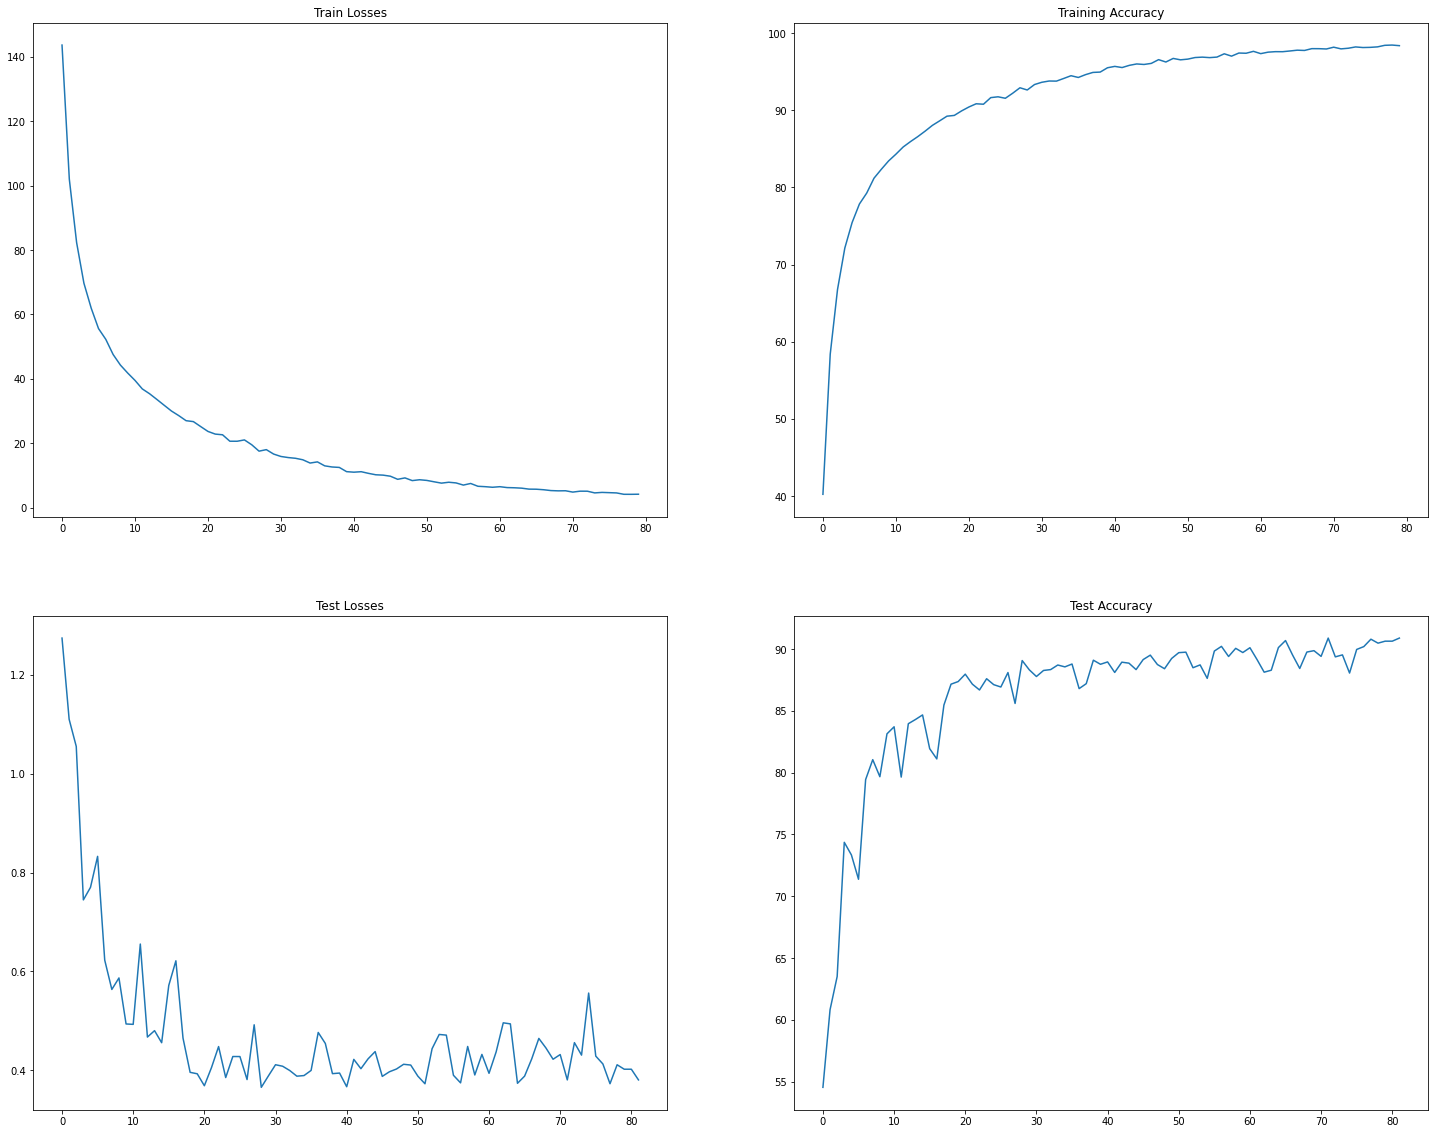

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)